In [1]:
import joblib, tqdm, torch

import numpy as np

from model.classifier import Classifier
from utilss.trainer import train
from utilss.dataloader import split
from utilss.get_labels import label_pts
from utilss.generate_data import xmin, xmax, ymin, ymax, b1, b2

import matplotlib.pyplot as plt
plt.style.use('bmh')

# Load data

We define a synthetic dataset with 3 classes over a 2-D feature space.

The boundaries of the dataset can be seen below:

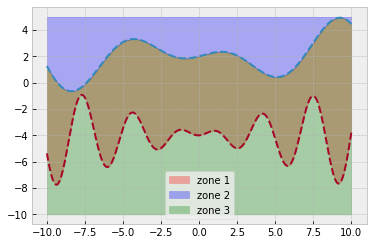

In [13]:
data = joblib.load('data/dataset_init.pt')

x = np.linspace(xmin, xmax, 1000)

bound1 = b1(x)
bound2 = b2(x)

plt.figure()
plt.plot(x, bound1, '--', label='_nolegend_')
plt.plot(x, bound2, '--', label='_nolegend_')

plt.fill_between(x, bound2, bound1, color = 'r', alpha = .3)
plt.fill_between(x, bound1, ymax, color = 'b', alpha = .3)
plt.fill_between(x, ymin, bound1, color='g', alpha=.3)

plt.legend(['zone 1', 'zone 2', 'zone 3'])
plt.show()


Our goal is to learn an accurate classification rule from data that can be sampled in the space.

Let's say we start off with a labeled dataset such as the following :

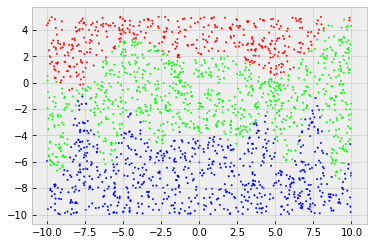

In [14]:
cloud = data['x']
labels = data['y']

plt.figure()
plt.scatter(cloud[:, 0], cloud[:, 1], c = labels, s = 2)
plt.show()

Clearly, this data is not enough to model transition boundaries with high precision, so the goal is to progressivey augment the dataset with samples that are close the boundaries in an Active learning framework.

Let's start with a classical training of the model.

In [15]:
data_train, data_test = split(data, perc = .75)

model = Classifier(input_dim = 2, output_dim = 3).to('cpu')
model.device = 'cpu'
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-2)
criterion = torch.nn.CrossEntropyLoss()

metrics1 = train(model, data_train, data_test, optimizer, criterion, active= False, n_epochs = 300, log=50)

optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
metrics2 = train(model, data_train, data_test, optimizer, criterion, active = False, n_epochs = 400, log=50)

metrics = {}
for k in metrics1.keys():
    metrics[k] = np.concatenate((metrics1[k], metrics2[k]))


  1%|          | 2/300 [00:00<00:54,  5.49it/s]

epoch : 0 - L_train : 0.008307428260644277 - L_val : 0.008014644682407378


 17%|█▋        | 51/300 [00:10<00:53,  4.69it/s]

epoch : 50 - L_train : 0.0029878714034954706 - L_val : 0.003510208398103714


 34%|███▍      | 103/300 [00:15<00:15, 12.64it/s]

epoch : 100 - L_train : 0.002716084375977516 - L_val : 0.0031755189299583434


 51%|█████     | 153/300 [00:19<00:11, 12.35it/s]

epoch : 150 - L_train : 0.0026185926323135694 - L_val : 0.002892246499657631


 68%|██████▊   | 203/300 [00:23<00:07, 12.39it/s]

epoch : 200 - L_train : 0.0022285900016625723 - L_val : 0.002536388576030731


 84%|████████▍ | 253/300 [00:27<00:03, 12.61it/s]

epoch : 250 - L_train : 0.0019854533970355987 - L_val : 0.0017880868539214133


  0%|          | 1/400 [00:00<00:40,  9.93it/s]

Done training.
epoch : 0 - L_train : 0.0014043817048271497 - L_val : 0.0014122468307614326


 13%|█▎        | 52/400 [00:03<00:21, 16.16it/s]

epoch : 50 - L_train : 0.0010349387874205908 - L_val : 0.001143676668405533


 26%|██▌       | 102/400 [00:06<00:18, 15.83it/s]

epoch : 100 - L_train : 0.0009480162933468818 - L_val : 0.0010120443478226662


 38%|███▊      | 152/400 [00:09<00:15, 16.23it/s]

epoch : 150 - L_train : 0.0008789683667322 - L_val : 0.0008939660340547561


 50%|█████     | 202/400 [00:13<00:12, 16.49it/s]

epoch : 200 - L_train : 0.0008208954619864623 - L_val : 0.000816415760666132


 63%|██████▎   | 253/400 [00:16<00:08, 16.68it/s]

epoch : 250 - L_train : 0.0007894903334478538 - L_val : 0.0007687321305274963


 76%|███████▌  | 303/400 [00:19<00:06, 14.35it/s]

epoch : 300 - L_train : 0.0007527098668118318 - L_val : 0.0007376136742532253


 88%|████████▊ | 351/400 [00:30<00:14,  3.34it/s]

epoch : 350 - L_train : 0.0007313681232432524 - L_val : 0.0006985552422702312


100%|██████████| 400/400 [00:43<00:00,  9.12it/s]

Done training.


We can clearly see that the model fails to learn the correct boundary, especially since more importance is given to data that is not along the boundaries, which is therefore more numerous and frequent during the training process.

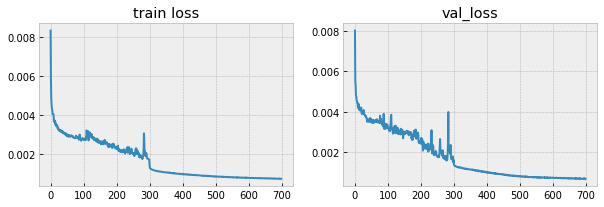

In [16]:
fig, ax = plt.subplots(1, 2, figsize = (10, 3))
ax[0].plot(metrics['L_train'])
ax[0].set_title('train loss')

ax[1].plot(metrics['L_val'])
ax[1].set_title('val_loss')
plt.show()

Let's see how well the model is able to separate th different domains.

In [17]:
labels_pred = model(torch.tensor(data_test['x']).float().to(model.device)).detach().numpy()

In [23]:
print(np.argmax(labels_pred, axis = 1, keepdims = True))

TypeError: _argmax_dispatcher() got an unexpected keyword argument 'keepdims'

Text(0.5, 1.0, 'predictions')

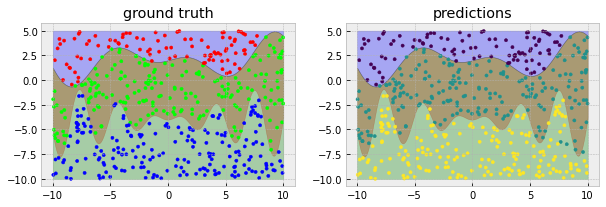

In [24]:
fig, ax = plt.subplots(1, 2, figsize = (10, 3))

ax[0].fill_between(x, bound2, bound1, color = 'r', alpha = .3)
ax[0].fill_between(x, bound1, ymax, color = 'b', alpha = .3)
ax[0].fill_between(x, ymin, bound1, color='g', alpha=.3)
ax[0].scatter(data_test['x'][:, 0], data_test['x'][:, 1], c = data_test['y'], s = 10)
ax[0].set_title('ground truth')

ax[1].fill_between(x, bound2, bound1, color = 'r', alpha = .3)
ax[1].fill_between(x, bound1, ymax, color = 'b', alpha = .3)
ax[1].fill_between(x, ymin, bound1, color='g', alpha=.3)
ax[1].scatter(data_test['x'][:, 0], data_test['x'][:, 1], c = labels_pred.argmax(axis=1), s =10)
ax[1].set_title('predictions')

In [25]:
n_pts = 20000
cloud = np.random.uniform(low=0, high = 1, size = (n_pts, 2))
cloud[:, 0] = cloud[:, 0]*(xmax - xmin) + xmin
cloud[:, 1] = cloud[:, 1]*(ymax - ymin) + ymin

cloud_pred = model(torch.tensor(cloud).float().to(model.device)).detach().numpy()
cloud_labels = label_pts(cloud)

Text(0.5, 1.0, 'predictions')

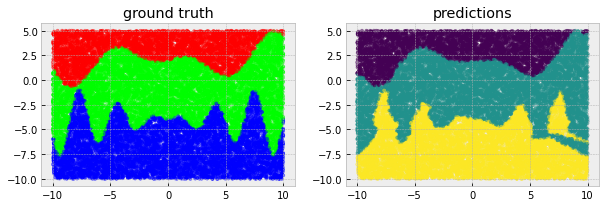

In [27]:
fig, ax = plt.subplots(1, 2, figsize = (10, 3))

ax[0].scatter(cloud[:, 0], cloud[:, 1], c = cloud_labels, s = 10, alpha = .5)
ax[0].set_title('ground truth')

ax[1].scatter(cloud[:, 0], cloud[:, 1], c = cloud_pred.argmax(axis = 1), s =10, alpha = .5)
ax[1].set_title('predictions')

# Approach 1

To obtain better results, we adopt the following approach :

During each training iteration, we keep track of the elements where the error on the confidence score is superior to a constant threshold and add it to a queue.

$$|1 - \mathbb{P}(\hat{y}/x)| > 1 - \epsilon$$

Afterwards, we sample points on the neighborhood of this set and generate their corresponding labels.

Finally, this new dataset is used to fit the model before going to the nex epoch.

In [28]:
model2 = Classifier(input_dim = 2, output_dim = 3).to('cpu')
model2.device = 'cpu'
optimizer = torch.optim.Adam(model2.parameters(), lr = 1e-2)
criterion = torch.nn.CrossEntropyLoss()

metrics1 = train(model2, data_train, data_test, optimizer, criterion, active = True, n_epochs = 300, log=50)

optimizer = torch.optim.Adam(model2.parameters(), lr = 1e-3)
metrics2 = train(model2, data_train, data_test, optimizer, criterion, active = True, n_epochs = 400, log=50)

metrics = {}
for k in metrics1.keys():
    metrics[k] = np.concatenate((metrics1[k], metrics2[k]))

  1%|          | 2/300 [00:00<01:36,  3.08it/s]

epoch : 0 - L_train : 0.008215988636016846 - L_val : 0.007000091016292572


 17%|█▋        | 52/300 [00:14<00:24, 10.32it/s]

epoch : 50 - L_train : 0.0028638484676678975 - L_val : 0.003420648276805878


 34%|███▍      | 102/300 [00:21<00:49,  3.98it/s]

epoch : 100 - L_train : 0.0027103594268361726 - L_val : 0.004360920786857605


 51%|█████     | 152/300 [00:27<00:16,  9.05it/s]

epoch : 150 - L_train : 0.002327425479888916 - L_val : 0.0023038913756608962


 67%|██████▋   | 202/300 [00:32<00:10,  9.17it/s]

epoch : 200 - L_train : 0.0016283010815580686 - L_val : 0.0016483177840709686


 84%|████████▍ | 252/300 [00:38<00:05,  8.23it/s]

epoch : 250 - L_train : 0.0016857193994025388 - L_val : 0.0014467763304710389


  0%|          | 2/400 [00:00<00:23, 16.85it/s]

Done training.
epoch : 0 - L_train : 0.0010226727277040481 - L_val : 0.0008604880142956972


 13%|█▎        | 52/400 [00:03<00:24, 14.18it/s]

epoch : 50 - L_train : 0.0007980907596647739 - L_val : 0.000624566663056612


 26%|██▌       | 102/400 [00:09<00:35,  8.36it/s]

epoch : 100 - L_train : 0.0007266106139868498 - L_val : 0.0005019394960254431


 38%|███▊      | 152/400 [00:15<00:27,  8.86it/s]

epoch : 150 - L_train : 0.0006494335488726696 - L_val : 0.0004292924394831061


 50%|█████     | 202/400 [00:20<00:22,  8.73it/s]

epoch : 200 - L_train : 0.0005607037094111244 - L_val : 0.00038009983114898206


 63%|██████▎   | 252/400 [00:26<00:21,  6.86it/s]

epoch : 250 - L_train : 0.0005001095868647098 - L_val : 0.0003433648953214288


 76%|███████▌  | 302/400 [00:33<00:12,  8.16it/s]

epoch : 300 - L_train : 0.0004443215245070557 - L_val : 0.0003214686457067728


 88%|████████▊ | 352/400 [00:39<00:05,  8.72it/s]

epoch : 350 - L_train : 0.00040632470898951093 - L_val : 0.0003001782214269042


100%|██████████| 400/400 [00:44<00:00,  8.90it/s]

Done training.


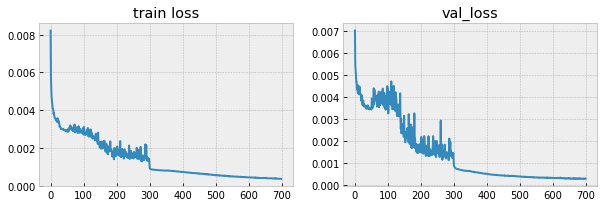

In [29]:
fig, ax = plt.subplots(1, 2, figsize = (10, 3))
ax[0].plot(metrics['L_train'])
ax[0].set_title('train loss')

ax[1].plot(metrics['L_val'])
ax[1].set_title('val_loss')
plt.show()

Text(0.5, 1.0, 'segmentation mask with active learning')

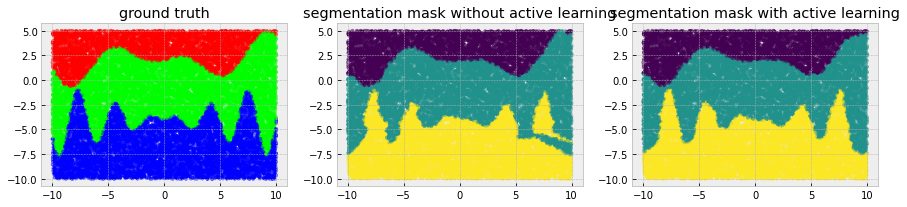

In [32]:
cloud_pred2 = model2(torch.tensor(cloud).float().to(model2.device)).detach().numpy()

fig, ax = plt.subplots(1, 3, figsize = (15, 3))

ax[0].scatter(cloud[:, 0], cloud[:, 1], c = cloud_labels, s = 10, alpha = .5)
ax[0].set_title('ground truth')

ax[1].scatter(cloud[:, 0], cloud[:, 1], c = cloud_pred.argmax(axis=1), s =10, alpha = .5)
ax[1].set_title('segmentation mask without active learning')

ax[2].scatter(cloud[:, 0], cloud[:, 1], c = cloud_pred2.argmax(axis=1), s =10, alpha = .5)
ax[2].set_title('segmentation mask with active learning')


In [33]:
u = joblib.load('aug.pt')

u.keys()

dict_keys(['x', 'y'])

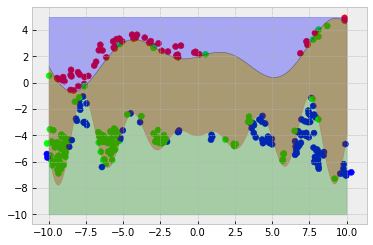

In [34]:
plt.scatter(u['x'][:, 0], u['x'][:, 1], c = u['y'])
plt.fill_between(x, bound2, bound1, color = 'r', alpha = .3)
plt.fill_between(x, bound1, ymax, color = 'b', alpha = .3)
plt.fill_between(x, ymin, bound1, color='g', alpha=.3)